# Anomaly Detection using GANs

Dataset from: Iman Sharafaldin, Arash Habibi Lashkari, and Ali A. Ghorbani, “Toward Generating a New Intrusion Detection Dataset and Intrusion Traffic Characterization”, 4th International Conference on Information Systems Security and Privacy (ICISSP), Portugal, January 2018

In [1]:
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Input, BatchNormalization, LeakyReLU, Dense, Reshape, Flatten, Activation 
from tensorflow.keras.layers import Dropout, multiply, GaussianNoise, MaxPooling2D, concatenate
from tensorflow.keras import initializers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint

2022-09-29 16:14:47.908789: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
import collections
import sys

import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd

from sklearn.metrics import roc_curve, auc,precision_recall_fscore_support, average_precision_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import precision_recall_curve, auc, confusion_matrix,accuracy_score, plot_confusion_matrix
from sklearn.model_selection import train_test_split

import seaborn as sns

from tqdm import tqdm

import helper_functions

pd.options.display.max_columns = None

In [3]:
filename = '../data/preprocessed_data.pickle'
figure_path = '../report/figures/gan/'

input_file = open(filename,'rb')
preprocessed_data = pickle.load(input_file)
input_file.close()

In [4]:
le = preprocessed_data['le']
x_train = preprocessed_data['x_train']
y_train = preprocessed_data['y_train']
x_test = preprocessed_data['x_test']
y_test = preprocessed_data['y_test']

In [5]:
pd.DataFrame(le.classes_, columns = ['Type'])

,Type
0,BENIGN
1,Bot
2,DDoS
3,DoS GoldenEye
4,DoS Hulk
5,DoS Slowhttptest
6,DoS slowloris
7,FTP-Patator
8,Heartbleed
9,Infiltration


In [6]:
assert x_train.shape[0] == y_train.shape[0]
assert x_test.shape[0] == y_test.shape[0]
assert x_train.shape[1] == x_test.shape[1]
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(2120907, 78)
(2120907,)
(706969, 78)
(706969,)


In [7]:
# Labels normal data as 0, anomalies as 1

def make_labels_binary(label_encoder, labels):
    normal_data_index = np.where(label_encoder.classes_ == 'BENIGN')[0][0]
    new_labels = labels.copy()
    new_labels[labels != normal_data_index] = 1
    new_labels[labels == normal_data_index] = 0
    return new_labels

In [8]:
y_train = make_labels_binary(le, y_train)
y_test = make_labels_binary(le, y_test)

In [9]:
print(f'Number of anomalies in y_train: {y_train.sum():,}')
print(f'Number of anomalies in y_test: {y_test.sum():,}')

Number of anomalies in y_train: 417,173
Number of anomalies in y_test: 139,383


In [10]:
prev_len = len(x_train)
temp_df = x_train.copy()

In [11]:
#Subsetting only Normal Network packets in training set (excluding anomalies)
temp_df['label'] = y_train

In [12]:
temp_df = temp_df.loc[temp_df['label'] == 0]
temp_df = temp_df.drop('label', axis = 1)
x_train = temp_df.copy()

print(f'Dataset has now the size of {(len(x_train)/prev_len):.2} of the original dataset')

Dataset has now the size of 0.8 of the original dataset


In [13]:
x_train

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
31805,80,47142,3,4,442,871,436,0,147.333333,250.010666,859,0,217.750000,427.509357,2.785202e+04,1.484875e+02,7.857000e+03,1.190133e+04,23344,4,23294,1.164700e+04,1.622103e+04,23117,177,24047,8015.666667,1.344935e+04,23543,4,0,0,0,0,72,92,6.363752e+01,84.850028,0,859,164.125000,319.058632,1.017984e+05,0,0,0,1,0,0,0,0,1,187.571429,147.333333,217.750000,72,0,0,0,0,0,0,3,442,4,871,8192,31,2,20,0.000000,0.0000,0,0,0.000000e+00,0.000000e+00,0,0
60865,51707,3,2,0,0,0,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000e+00,6.666667e+05,3.000000e+00,0.000000e+00,3,3,3,3.000000e+00,0.000000e+00,3,3,0,0.000000,0.000000e+00,0,0,0,0,0,0,40,0,6.666667e+05,0.000000,0,0,0.000000,0.000000,0.000000e+00,0,0,0,0,1,0,0,0,0,0.000000,0.000000,0.000000,40,0,0,0,0,0,0,2,0,0,0,5181,-1,0,20,0.000000,0.0000,0,0,0.000000e+00,0.000000e+00,0,0
173108,54225,83,1,1,0,0,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000e+00,2.409639e+04,8.300000e+01,0.000000e+00,83,83,0,0.000000e+00,0.000000e+00,0,0,0,0.000000,0.000000e+00,0,0,0,0,0,0,32,32,1.204819e+04,12048.192771,0,0,0.000000,0.000000,0.000000e+00,0,0,0,0,1,0,0,0,1,0.000000,0.000000,0.000000,32,0,0,0,0,0,0,1,0,1,0,117,33304,0,32,0.000000,0.0000,0,0,0.000000e+00,0.000000e+00,0,0
507160,53,30638,2,2,70,134,35,35,35.000000,0.000000,67,67,67.000000,0.000000,6.658398e+03,1.305568e+02,1.021267e+04,1.768626e+04,30635,0,0,0.000000e+00,0.000000e+00,0,0,3,3.000000,0.000000e+00,3,3,0,0,0,0,80,64,6.527841e+01,65.278412,35,67,47.800000,17.527122,3.072000e+02,0,0,0,0,0,0,0,0,1,59.750000,35.000000,67.000000,80,0,0,0,0,0,0,2,70,2,134,-1,-1,1,40,0.000000,0.0000,0,0,0.000000e+00,0.000000e+00,0,0
63403,3120,1,2,0,0,0,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000e+00,2.000000e+06,1.000000e+00,0.000000e+00,1,1,1,1.000000e+00,0.000000e+00,1,1,0,0.000000,0.000000e+00,0,0,0,0,0,0,40,0,2.000000e+06,0.000000,0,0,0.000000,0.000000,0.000000e+00,0,0,0,0,1,0,0,0,0,0.000000,0.000000,0.000000,40,0,0,0,0,0,0,2,0,0,0,2559,-1,0,20,0.000000,0.0000,0,0,0.000000e+00,0.000000e+00,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
312645,80,2166817,4,4,827,1427,827,0,206.750000,413.500000,1427,0,356.750000,713.500000,1.040236e+03,3.692052e+00,3.095453e+05,7.180475e+05,1933722,224,233095,7.769833e+04,8.789678e+04,179156,24603,2142438,714146.000000,1.187614e+06,2085171,3246,0,0,0,0,92,92,1.846026e+00,1.846026,0,1427,250.444444,519.104544,2.694695e+05,0,0,0,1,0,0,0,0,1,281.750000,206.750000,356.7

In [14]:
scaler = MinMaxScaler()

x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [15]:
dataset = {}
dataset['x_train'] = x_train.astype(np.float32)
dataset['y_train'] = y_train.astype(np.float32)
dataset['x_test']  = x_test.astype(np.float32)
dataset['y_test']  = y_test.astype(np.float32)

In [16]:
normals = collections.Counter(y_test)[0]
anomalies = collections.Counter(y_test)[1]
anomalies_percentage = anomalies / (normals + anomalies)
print('Number of Normal Network packets in the test set:', normals)
print('Number of Anomalous Network packets in the test set:', anomalies)
print('Ratio of anomalous to normal network packets: ', anomalies_percentage)

Number of Normal Network packets in the test set: 567586
Number of Anomalous Network packets in the test set: 139383
Ratio of anomalous to normal network packets:  0.19715574515997164


In [17]:
def get_generator(optim):
    generator = Sequential()
    generator.add(Dense(64, input_dim=78, kernel_initializer=initializers.glorot_normal(seed=42)))
    generator.add(Activation('tanh'))
    
    generator.add(Dense(128))
    generator.add(Activation('tanh'))
        
    generator.add(Dense(256))
    generator.add(Activation('tanh'))
       
    generator.add(Dense(78, activation='tanh'))
    
    generator.compile(loss='binary_crossentropy', optimizer=optim)
    
    return generator

def get_discriminator(optim):
    
    discriminator = Sequential()
    
    discriminator.add(Dense(256, input_dim=78, kernel_initializer=initializers.glorot_normal(seed=42)))
    discriminator.add(Activation(tf.nn.leaky_relu))
    discriminator.add(Dropout(0.2))
        
    discriminator.add(Dense(128))
    discriminator.add(Activation(tf.nn.leaky_relu))
    discriminator.add(Dropout(0.2))
    
    discriminator.add(Dense(1))
    discriminator.add(Activation('sigmoid'))
   
    discriminator.compile(loss='binary_crossentropy', optimizer=optim)

    return discriminator


In [18]:
def make_gan_network(discriminator, generator, optim, input_dim=78):
    discriminator.trainable = False
    gan_input = Input(shape=(input_dim,))  
    x = generator(gan_input)        
    gan_output = discriminator(x)
    
    gan = Model(inputs=gan_input, outputs=gan_output)    
    gan.compile(loss='binary_crossentropy', optimizer=optim)
    
    return gan

In [19]:
learning_rate = 0.00001
momentum = 0.3
batch_size = 512
epochs = 10
adam = Adam(lr = learning_rate, beta_1 = momentum)

def get_generator(optim):
    generator = Sequential()
    generator.add(Dense(64, input_dim=78, kernel_initializer=initializers.glorot_normal(seed=42)))
    generator.add(Activation('tanh'))
    
    generator.add(Dense(128))
    generator.add(Activation('tanh'))
        
    generator.add(Dense(256))
    generator.add(Activation('tanh'))
    
    generator.add(Dense(256))
    generator.add(Activation('tanh'))
    
    generator.add(Dense(256))
    generator.add(Activation('tanh'))
    
    generator.add(Dense(256))
    generator.add(Activation('tanh'))
    
    generator.add(Dense(256))
    generator.add(Activation('tanh'))
    
    generator.add(Dense(1028))
    generator.add(Activation('tanh'))
       
    generator.add(Dense(78, activation='tanh'))
    
    generator.compile(loss='binary_crossentropy', optimizer=optim)
    
    return generator

def get_discriminator(optim):
    
    discriminator = Sequential()
    
    discriminator.add(Dense(256, input_dim=78, kernel_initializer=initializers.glorot_normal(seed=42)))
    discriminator.add(Activation(tf.nn.leaky_relu))
    discriminator.add(Dropout(0.2))
    
    discriminator.add(Dense(128))
    discriminator.add(Activation(tf.nn.leaky_relu))
    discriminator.add(Dropout(0.2))
    
    discriminator.add(Dense(256))
    discriminator.add(Activation(tf.nn.leaky_relu))
    discriminator.add(Dropout(0.2))
    
    discriminator.add(Dense(1028))
    discriminator.add(Activation(tf.nn.leaky_relu))
    discriminator.add(Dropout(0.2))

    discriminator.add(Dense(128))
    discriminator.add(Activation(tf.nn.leaky_relu))
    discriminator.add(Dropout(0.2))
    
    discriminator.add(Dense(1))
    discriminator.add(Activation('sigmoid'))
   
    discriminator.compile(loss='binary_crossentropy', optimizer=optim)

    return discriminator

learning_rate = 0.00001
momentum = 0.3
batch_size = 512
epochs = 5
adam = Adam(lr = learning_rate, beta_1 = momentum)

Accuracy Score : 0.8385586921067261
Precision : 0.5892840725050744
Recall : 0.5977988707374644
F1 : 0.5935109338271957

In [20]:
# Training the GAN
x_train, y_train, x_test, y_test = dataset['x_train'], dataset['y_train'], dataset['x_test'], dataset['y_test']

In [21]:
x_train

array([[1.2207218e-03, 3.9295829e-04, 9.1009197e-06, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [7.8899825e-01, 1.3333332e-07, 4.5504598e-06, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [8.2742047e-01, 7.9999995e-07, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       ...,
       [6.7597469e-03, 9.6972543e-01, 2.3662392e-04, ..., 1.7619176e-02,
        8.3539620e-02, 4.4380091e-02],
       [1.2207218e-03, 2.5155154e-01, 2.2752300e-05, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [8.0872816e-04, 8.4505824e-04, 4.5504598e-06, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00]], dtype=float32)

In [22]:
#Calculating the number of batches based on the batch size
batch_count = x_train.shape[0] // batch_size
pbar = tqdm(total=epochs * batch_count, position=0, leave=True)
gan_loss = []
discriminator_loss = []

#Inititalizing the network
generator = get_generator(adam)
discriminator = get_discriminator(adam)
gan = make_gan_network(discriminator, generator, adam, input_dim=78)


for epoch in range(epochs):
    for index in range(batch_count):
        pbar.update(1)
        # Creating a random set of input noise and images
        noise = np.random.normal(0, 1, size=[batch_size,78])
        
        # Generate fake samples
        generated_images = generator.predict_on_batch(noise)
        
        #Obtain a batch of normal network packets
        image_batch = x_train[index * batch_size: (index + 1) * batch_size]
        
        X = np.vstack((generated_images, image_batch))       
        y_dis = np.ones(2*batch_size) 
        y_dis[:batch_size] = 0

        # Train discriminator
        discriminator.trainable = True
        d_loss= discriminator.train_on_batch(X, y_dis)

        # Train generator
        noise = np.random.uniform(0, 1, size=[batch_size, 78])
        y_gen = np.ones(batch_size)
        discriminator.trainable = False
        g_loss = gan.train_on_batch(noise, y_gen)
        
        #Record the losses
        discriminator_loss.append(d_loss)
        gan_loss.append(g_loss)
        
    print("Epoch %d Batch %d/%d [D loss: %f] [G loss:%f]" % (epoch,index, batch_count, d_loss, g_loss))


  0%|                                                                                                                                                               | 0/33270 [00:00<?, ?it/s]2022-09-29 16:15:14.618893: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-09-29 16:15:14.633871: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-09-29 16:15:14.660268: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-29 16:15:14.661229: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:25:00.0 name: NVIDIA GeForce GTX 1060 6GB computeCapability: 6.1
coreClock: 1.7335GHz coreCount: 10 deviceMemorySize: 5.93GiB deviceMemoryBandwidth: 178.99GiB/s
2022-09-29 16:15:14

Epoch 0 Batch 3326/3327 [D loss: 0.093039] [G loss:0.041159]


 20%|█████████████████████████████▌                                                                                                                      | 6655/33270 [01:53<21:24, 20.72it/s]

Epoch 1 Batch 3326/3327 [D loss: 0.035530] [G loss:0.005637]


 30%|████████████████████████████████████████████▍                                                                                                       | 9985/33270 [03:03<16:35, 23.39it/s]

Epoch 2 Batch 3326/3327 [D loss: 0.019892] [G loss:0.001837]


 40%|██████████████████████████████████████████████████████████▊                                                                                        | 13316/33270 [04:14<09:04, 36.67it/s]

Epoch 3 Batch 3326/3327 [D loss: 0.014487] [G loss:0.001173]


 50%|█████████████████████████████████████████████████████████████████████████▌                                                                         | 16648/33270 [04:57<02:47, 99.04it/s]

Epoch 4 Batch 3326/3327 [D loss: 0.021257] [G loss:0.001714]


 60%|████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 19976/33270 [05:31<02:18, 95.89it/s]

Epoch 5 Batch 3326/3327 [D loss: 0.022620] [G loss:0.004247]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 23304/33270 [06:09<01:42, 97.25it/s]

Epoch 6 Batch 3326/3327 [D loss: 0.021621] [G loss:0.002428]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 26627/33270 [06:44<01:11, 93.23it/s]

Epoch 7 Batch 3326/3327 [D loss: 0.018579] [G loss:0.001905]


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 29958/33270 [07:19<00:33, 97.44it/s]

Epoch 8 Batch 3326/3327 [D loss: 0.023244] [G loss:0.003014]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 33269/33270 [07:53<00:00, 94.08it/s]

Epoch 9 Batch 3326/3327 [D loss: 0.018772] [G loss:0.004728]


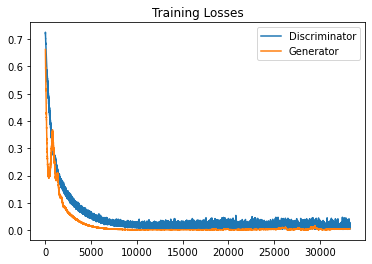

In [23]:
fig, ax = plt.subplots()
plt.plot(discriminator_loss, label='Discriminator')
plt.plot(gan_loss, label='Generator')
plt.title("Training Losses")
plt.legend()
plt.savefig(figure_path + 'loss_gan.png')

In [24]:
nr_batches_test = np.ceil(x_test.shape[0] // batch_size).astype(np.int32)

results = []

for t in range(nr_batches_test +1):
        ran_from = t * batch_size
        ran_to = (t + 1) * batch_size
        image_batch = x_test[ran_from:ran_to]             
        tmp_rslt = discriminator.predict(x=image_batch,batch_size=128,verbose=0)
        results = np.append(results, tmp_rslt)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33270/33270 [08:10<00:00, 94.08it/s]

In [25]:
pd.options.display.float_format = '{:20,.7f}'.format
results_df = pd.concat([pd.DataFrame(results),pd.DataFrame(y_test)], axis=1)
results_df.columns = ['results','y_test']
print('Mean score for normal packets :', results_df.loc[results_df['y_test'] == 0, 'results'].mean() )
print('Mean score for anomalous packets :', results_df.loc[results_df['y_test'] == 1, 'results'].mean())

Mean score for normal packets : 0.9951458027430777
Mean score for anomalous packets : 0.9052464939704288


## Thresholds

In [26]:
#Obtaining the lowest "anomalies_percentage" score
per = np.percentile(results, anomalies_percentage*100)
y_pred = results.copy()
y_pred = np.array(y_pred)

In [27]:
#Thresholding based on the score
inds = (y_pred > per)
inds_comp = (y_pred <= per)
y_pred[inds] = 0
y_pred[inds_comp] = 1

precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
print('Accuracy Score :', accuracy_score(y_test, y_pred))
print('Precision :', precision)
print('Recall :', recall)
print('F1 :', f1)

Accuracy Score : 0.8225650629659857
Precision : 0.5500129139643001
Recall : 0.5500168600187971
F1 : 0.5500148869844709


In [28]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc_curve = auc(fpr, tpr)


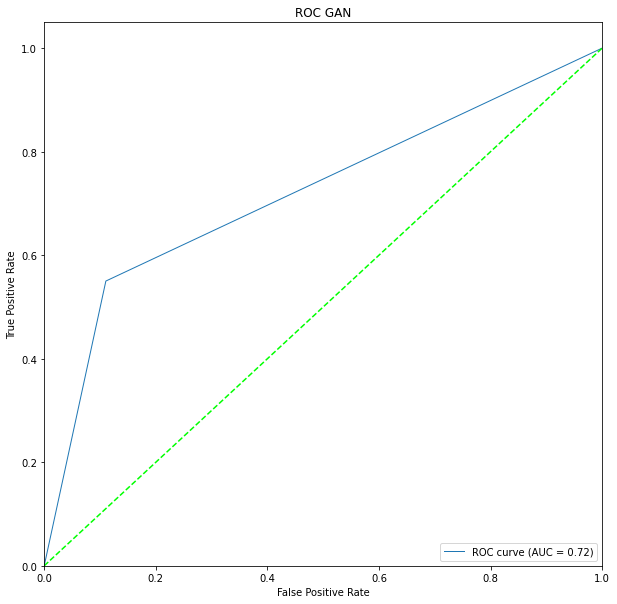

In [29]:
helper_functions.plot_roc(tpr, fpr, auc_curve, figure_path + 'confusion_gan.png', 'GAN')

In [30]:
cm = confusion_matrix(y_test, y_pred)

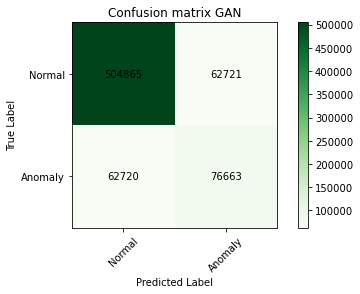

In [31]:
helper_functions.plot_confusion_matrix(cm, figure_path + 'confusion_gan.png', 'GAN')